In this notebook, I will be working on the "Mountain Car" (discrete) environment that can be found in the gym library.<br/>
The observation space in this environment is composed of the position of the car (along the x-axis) along with its velocity :
- The position is clipped to the range `[-1.2, 0.6]`
- The velocity is clipped to the range `[-0.07, 0.07]`<br/>

There are 3 discrete deterministic actions :
- Accelerate to the left
- Don't do anything
- Accelerate to the right<br/>

The default reward provided when using this environment is a peanlity of -1 for each timestep passed before reaching the goal.<br/>

An episode ends by either reaching the objective or by reaching a maximum episode length.

More information concerning the environment can be found in [the official documentation ](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py).

First of all, we need to import all the necessary libraries :

In [2]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from collections import namedtuple, deque

In [3]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000
env.seed(1)

[1]

To confirm a part of what we mentioned earlier :

In [4]:
print("The size of state is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
print(env.action_space)

The size of state is:  (2,)
No. of Actions:  3
Discrete(3)


We can show an example of an episode in this environment (using a totally random policy) :

In [5]:
def random_play():
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

C:\Users\alaae\anaconda3\envs\torch_env\lib\site-packages\pyglet\image\codecs\wic.py:434: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Now we need to create our agent class that can work based on a epsilon-greedy algorithm to allow exploration.

The epsilon constant is used to balance between exploration and exploitation. We can use a decaying epsilon as we may want to explore less the more we learn.

In [6]:
class Agent():
    def __init__(self, eps = 0., eps_decay = 0., min_eps = 0.,
                 GAMMA = 0.99, LR = 0.1, p_size = 24, v_size = 40,
                 action_size = 3):
        self.action_space = list(range(0, action_size))
        self.pos_space = np.linspace(-1.2, 0.6, p_size)
        self.vel_space = np.linspace(-0.07, 0.07, v_size)
        
        self.GAMMA = GAMMA         # discount factor
        self.LR = LR               # learning rate
        self.eps = eps             # epsilon
        self.eps_decay = eps_decay # decay rate of epsilon
        self.min_eps = min_eps     # minimum possible value of epsilon
        
        self.scores = []
        self.scores_window = deque(maxlen=50)
        
        # Intilizing state
        self.states = []
        for p in range(p_size + 1):
            for v in range(v_size + 1):
                self.states.append((p, v))
        
        # Iitliazing Q
        self.Q = {}
        for s in self.states:
            for a in self.action_space:
                self.Q[s, a] = 0
        
                
    def decay(self):
        self.eps = self.eps - self.eps_decay \
                    if self.eps>self.min_eps else self.min_eps
        
    def get_state(self, state):
        """Returns a discrete version of the state."""
        pos, vel = state
        pos_bin = np.digitize(pos, self.pos_space)
        vel_bin = np.digitize(vel, self.vel_space)
        return pos_bin, vel_bin
    
    
    def act(self, state):
        """Returns actions for given state as per action value function."""
        state = self.get_state(state)
        values = np.array([self.Q[state, a] for a in self.action_space])
        action = np.argmax(values)
        g_action = np.random.choice(self.action_space) if np.random.random() < self.eps else action 
        return g_action
        
    def step(self, s, a, ns, r):
        """Updates the state-action values (Q)."""
        na = self.act(ns)
        s = self.get_state(s)
        ns = self.get_state(ns)
        self.Q[s, a] = self.Q[s, a] + self.LR * (r + (self.GAMMA * self.Q[ns, na]) - self.Q[s, a])
        
    def learn(self, n_episodes=50000, verbose = 0):
        """trains the agent"""
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            while True:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                self.step(state, action, next_state, reward)
                score += reward
                state = next_state
                if done:
                    break
            self.decay()
            self.scores_window.append(score)      
            self.scores.append(score)             
            if (verbose != 0):
                print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(self.scores_window)}\tEpsilion: {self.eps}', end="")
                if i_episode % (n_episodes//100) == 0:
                    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(self.scores_window)}\tEpsilion: {self.eps}')

In [43]:
agent = Agent(eps = 1., eps_decay = 4e-5, min_eps = 0.1, p_size=12, v_size=20, action_size= 3)

In [40]:
# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break 
        
env.close()

Episode 500	Average Score: -1000.0	Epsilion: 0.9799999999999801
Episode 1000	Average Score: -1000.0	Epsilion: 0.959999999999961
Episode 1500	Average Score: -998.5	Epsilion: 0.93999999999994011
Episode 2000	Average Score: -986.46	Epsilion: 0.9199999999999201
Episode 2500	Average Score: -976.02	Epsilion: 0.8999999999999001
Episode 3000	Average Score: -980.64	Epsilion: 0.8799999999998801
Episode 3500	Average Score: -982.6	Epsilion: 0.85999999999986017
Episode 4000	Average Score: -979.64	Epsilion: 0.8399999999998401
Episode 4500	Average Score: -924.04	Epsilion: 0.8199999999998201
Episode 5000	Average Score: -883.38	Epsilion: 0.7999999999998001
Episode 5500	Average Score: -821.32	Epsilion: 0.7799999999997801
Episode 6000	Average Score: -832.86	Epsilion: 0.7599999999997601
Episode 6500	Average Score: -783.84	Epsilion: 0.7399999999997401
Episode 7000	Average Score: -731.4	Epsilion: 0.71999999999972201
Episode 7500	Average Score: -595.64	Epsilion: 0.6999999999997011
Episode 8000	Average Score:

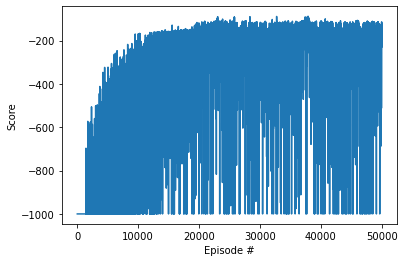

In [44]:
agent.learn(n_episodes=50000, verbose = 1)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(agent.scores)), agent.scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Through the following graph we can see that the agent has learn pretty well to consistently climb the mountain in a small amount of time :

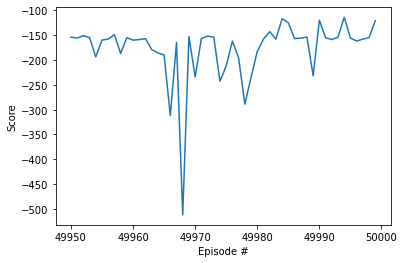

In [52]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(49950+np.arange(len(agent.scores_window)), agent.scores_window)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [54]:
# watch a trained agent
l = []
r = []
state = env.reset()
score = 0
while True:
    env.render()
    action = agent.act(state)
    env.render(mode='human')
    state, reward, done, _ = env.step(action)
    r.append(reward)
    l.append(state)
    score += reward
    if done:
        print("Your total score is: ", score)
        break 
        
env.close()

Your total score is:  -126.0


We can observe that the agent has learnt to go backwards sufficiently that it has enough momentum to move forward and climb the mountain :

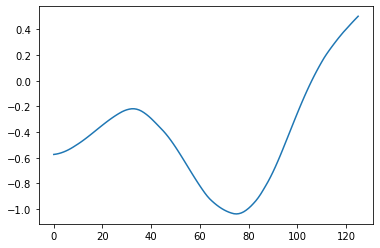

In [55]:
plt.plot(np.array(l)[:,0])

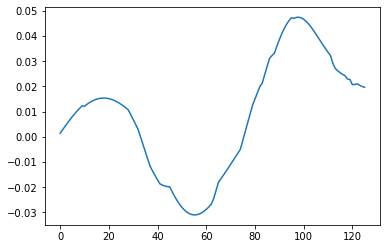

In [56]:
plt.plot(np.array(l)[:,1])

In the remaining of the notebook I experimented with a different rewards' system to find out if I can decrease the time needed to reach the target.

Basically, the agent will be rewarded the closer it gets to the objective in addition to the -1 penalty :

In [11]:
def calculate_reward(next_state):
    reward = 0
    if (next_state[0]>0):
        reward += 3*next_state[0]
    return reward

In [12]:
class Agent2():
    def __init__(self, eps = 0., eps_decay = 0., min_eps = 0.,
                 GAMMA = 0.99, LR = 0.1, p_size = 24, v_size = 40,
                 action_size = 3):
        self.action_space = list(range(0, action_size))
        self.pos_space = np.linspace(-1.2, 0.6, p_size)
        self.vel_space = np.linspace(-0.07, 0.07, v_size)
        
        self.GAMMA = GAMMA         # discount factor
        self.LR = LR               # learning rate
        self.eps = eps             # epsilon
        self.eps_decay = eps_decay # decay rate of epsilon
        self.min_eps = min_eps     # minimum possible value of epsilon
        
        self.scores = []
        self.scores_window = deque(maxlen=50)
        
        # Intilizing state
        self.states = []
        for p in range(p_size + 1):
            for v in range(v_size + 1):
                self.states.append((p, v))
        
        # Iitliazing Q
        self.Q = {}
        for s in self.states:
            for a in self.action_space:
                self.Q[s, a] = 0
        
                
    def decay(self):
        self.eps = self.eps - self.eps_decay \
                    if self.eps>self.min_eps else self.min_eps
        
    def get_state(self, state):
        """Returns a discrete version of the state."""
        pos, vel = state
        pos_bin = np.digitize(pos, self.pos_space)
        vel_bin = np.digitize(vel, self.vel_space)
        return pos_bin, vel_bin
    
    
    def act(self, state):
        """Returns actions for given state as per action value function."""
        state = self.get_state(state)
        values = np.array([self.Q[state, a] for a in self.action_space])
        action = np.argmax(values)
        g_action = np.random.choice(self.action_space) if np.random.random() < self.eps else action 
        return g_action
        
    def step(self, s, a, ns, r):
        """Updates the state-action values (Q)."""
        na = self.act(ns)
        s = self.get_state(s)
        ns = self.get_state(ns)
        self.Q[s, a] = self.Q[s, a] + self.LR * (r + (self.GAMMA * self.Q[ns, na]) - self.Q[s, a])
        
    def learn(self, n_episodes=50000, verbose = 0):
        """trains the agent"""
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            while True:
                action = self.act(state)
                next_state, reward1, done, _ = env.step(action)
                reward2 = calculate_reward(next_state)
                self.step(state, action, next_state, reward1+reward2)
                score += reward1
                state = next_state
                if done:
                    break
            self.decay()
            self.scores_window.append(score)      
            self.scores.append(score)             
            if (verbose != 0):
                print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(self.scores_window)}\tEpsilion: {self.eps}', end="")
                if i_episode % (n_episodes//100) == 0:
                    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(self.scores_window)}\tEpsilion: {self.eps}')

Episode 250	Average Score: -1000.0	Epsilion: 0.9899999999999901
Episode 500	Average Score: -1000.0	Epsilion: 0.9799999999999801
Episode 750	Average Score: -1000.0	Epsilion: 0.9699999999999701
Episode 1000	Average Score: -996.24	Epsilion: 0.959999999999961
Episode 1250	Average Score: -1000.0	Epsilion: 0.9499999999999501
Episode 1500	Average Score: -999.08	Epsilion: 0.9399999999999401
Episode 1750	Average Score: -1000.0	Epsilion: 0.9299999999999301
Episode 2000	Average Score: -993.26	Epsilion: 0.9199999999999201
Episode 2250	Average Score: -971.34	Epsilion: 0.9099999999999101
Episode 2500	Average Score: -978.14	Epsilion: 0.8999999999999001
Episode 2750	Average Score: -962.2	Epsilion: 0.88999999999989914
Episode 3000	Average Score: -984.6	Epsilion: 0.87999999999988012
Episode 3250	Average Score: -974.84	Epsilion: 0.8699999999998701
Episode 3500	Average Score: -979.3	Epsilion: 0.85999999999986601
Episode 3750	Average Score: -980.9	Epsilion: 0.84999999999985013
Episode 4000	Average Score: -

NameError: name 'agent' is not defined

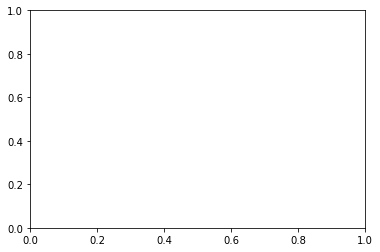

In [13]:
agent2 = Agent2(eps = 1., eps_decay = 4e-5, min_eps = 0.1, p_size=12, v_size=20, action_size= 3)
agent2.learn(n_episodes=25000, verbose = 1)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(agent.scores)), agent.scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

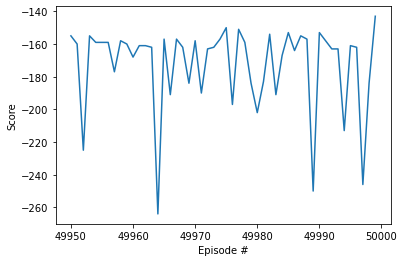

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(49950+np.arange(len(agent2.scores_window)), agent2.scores_window)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [21]:
# watch a trained agent
l = []
r = []
state = env.reset()
score = 0
while True:
    env.render()
    action = agent2.act(state)
    env.render(mode='human')
    state, reward, done, _ = env.step(action)
    r.append(reward)
    l.append(state)
    score += reward
    if done:
        print("Your total score is: ", score)
        break 
        
env.close()

Your total score is:  -157.0


We can observe from the following figure that the strategy taken by the agent has changed slightly due to the different rewarding system; it is going backwards since the beginning to ensure that it goes as far forward as possible : 

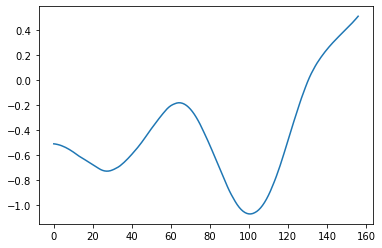

In [22]:
plt.plot(np.array(l)[:,0])

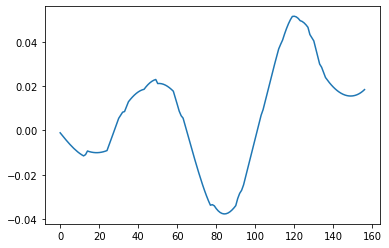

In [24]:
plt.plot(np.array(l)[:,1])